In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Hyperparameter tuning with Random Forest

Hyperparameter tuning is the process of optimizing model parameters to improve performance.
Random forest is an ensemble learning method that builds multiple decision trees and merges their predictions for more robust and accurate results.

Based on https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

# set default figure size for plots
plt.rcParams['figure.figsize'] = 9, 6

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

# turn off all kinds of warnings
# import warnings
# warnings.filterwarnings("ignore")

## Plotting function


This function plots the validation curve showing training and cross-validation scores.
Tt helps visualize the effect of changing a hyperparameter on model performance.

In [3]:
def plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.title("validation Curve")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.991, 1.001)
    lw = 2
    plt.semilogx(param_range, 
                 train_scores_mean, 
                 label="Training score",
                 color="darkorange", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2,
                     color="darkorange", 
                     lw=lw
                    )
    plt.semilogx(param_range, 
                 test_scores_mean, 
                 label="Cross-validation score",
                 color="navy", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.2,
                     color="navy", 
                     lw=lw
                    )
    plt.legend(loc="best")    
    return

## Wine dataset with split ratio 65:35

This example uses the wine quality dataset from the uci repository.
It combines red and white wines and adds a `color` target column for classification.

>Database Link: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [4]:
red = pd.read_csv('data/winequality-red.csv', delimiter=';')
red['color'] = 1

white = pd.read_csv('data/winequality-white.csv', delimiter=';')
white['color'] = 0

data = pd.concat([red, white], ignore_index=True, sort=False)
n_samples, n_features = data.shape
n_samples, n_features

(6497, 13)

#### Add noisy columns (simulate real data)

Adding additional noisy features to simulate a more realistic scenario.
This increases the number of features and complexity for hyperparameter tuning.

In [5]:
# you can try a change to 100 to see the computational effect
n_cols = 20 * n_features
random_state = np.random.RandomState(0)
df_cols = pd.DataFrame(data=random_state.randn(n_samples, n_cols),
                       columns=range(1, n_cols+1)
                      )
print(df_cols.shape)

data = pd.concat([data, df_cols], axis=1)
data.columns = data.columns.astype(str)
# data.head(10)
data.shape

(6497, 260)


(6497, 273)

#### Split dataset

Splitting the dataset into training and testing sets is crucial for evaluating model generalization.
Here we use a 65:35 split. _You can experiment with different ratios_.

In [6]:
train, test = train_test_split(data, test_size=0.35, shuffle=True, stratify=None)
print(len(train), len(test))

x_train, y_train = train.loc[:, train.columns != 'color'], train['color']
x_test, y_test = test.loc[:, test.columns != 'color'], test['color']

4223 2274


### Random Forest Classifier

Random forest by default uses 100 trees (`n_estimators=100`).
It aggregates multiple decision trees to reduce overfitting and improve accuracy.

In [7]:
forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("accuracy:", accuracy_score(y_test, y_pred))

accuracy 0.9929639401934917


## Hyperparameter *n_estimators* tuning

Tuning `n_estimators` changes the number of trees in the forest, affecting both performance and computation.

>! Note: long-running time - a few minutes.


In [8]:
# param_range = [100, 200, 300, 400, 500]
param_range = [100, 200]

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             X = x_train, 
                                             y = y_train, 
                                             param_name = 'n_estimators', 
                                             param_range = param_range, 
                                             scoring="accuracy",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(train_scores)
print(test_scores)

[[1. 1. 1.]
 [1. 1. 1.]]
[[0.98721591 0.98721591 0.98933902]
 [0.98721591 0.98934659 0.98791756]]


## Plotting

The validation curve is plotted to compare training and cross-validation performance.
It assists in identifying the optimal number of estimators.

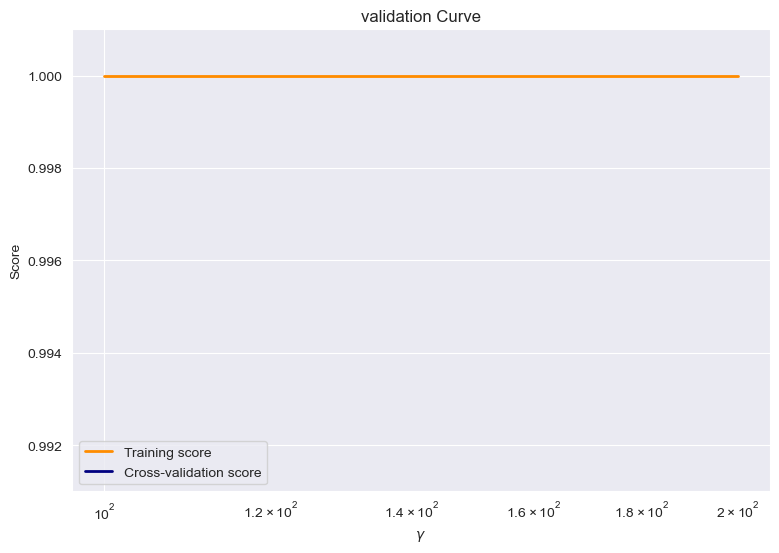

In [9]:
plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

## Random Forest with hyperparameter setting

After tuning, we set the hyperparameters for the random forest.
This example uses `n_estimators=200` with default tree parameters.

In [10]:
forest = RandomForestClassifier(random_state = 1,
                                n_estimators = 200,
                                max_depth = None, 
                                min_samples_split = 2,  
                                min_samples_leaf = 1
                               )
model = forest.fit(x_train, y_train) 
y_pred = model.predict(x_test)

print("accuracy:", accuracy_score(y_test, y_pred))

accuracy: 0.9942832014072119


## Grid Search

Grid search exhaustively tests hyperparameter combinations to find the best model settings.

>! Note: long-running time ~ 30 min.

In [11]:
# n_estimators = [100, 200, 300, 400, 500]
# max_depth = [5, 10, 20, 30, 40, 50]
# min_samples_split = [2, 5, 10, 15, 20]
# min_samples_leaf = [1, 2, 5, 10]

n_estimators = [100, 200]
max_depth = [5, 10, 20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]

hyper = dict(n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )
gs = GridSearchCV(forest, hyper, cv=3, verbose=1, n_jobs=-1)

best = gs.fit(x_train, y_train)
print("best:", best)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=200, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)


## The best model

The final model is trained using the best hyperparameters found.
This model is expected to generalize better and yield higher accuracy.

In [12]:
forest = RandomForestClassifier(n_estimators=200, random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("accuracy:", accuracy_score(y_test, y_pred))

0.9942832014072119


# Homework (just) to think about:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- different split ratio 65:35, 70:30, 75:25, 80:20
- different hyperpamater settings
- different criterion{"gini", "entropy"}
- different classifiers
- different metrics
- different datasets

### **The Quest**
- What is the best model?
- Is the score good enough?
- Do we need more tuning for this concrete case?

### **Auxiliaries**
- Nice visualizations of data and/or results